<a href="https://colab.research.google.com/github/Kamalika-13/Sentimental_Analysis/blob/main/Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas matplotlib seaborn wordcloud nltk scikit-learn tensorflow


  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl (331.7 MB)
  Using cached keras-3.12.0-py3-none-any.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kamali\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kamali\AppData\Roaming\nltk_data...


True

In [ ]:
num_words = 10000  # keep top 10k words
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
print(len(x_train), 'train reviews')
print(len(x_test), 'test reviews')


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
25000 train reviews
25000 test reviews


In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<OOV>"

def decode_review(encoded_review):
    return " ".join(reverse_word_index.get(i, "?") for i in encoded_review)

print("Sample review:", decode_review(x_train[0]))
print("Label:", y_train[0])  # 1 = positive, 0 = negative


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Sample review: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <OOV> to the two little boy's that played the <OOV> of norman and paul they were just brilliant children are often left out of the <OOV> list i think because the stars that play them all grown up are such a big profile for the whole f

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}


In [ ]:
review_lengths = [len(r) for r in x_train]
print("Average length:", np.mean(review_lengths))
print("Max length:", np.max(review_lengths))


Average length: 238.71364
Max length: 2494


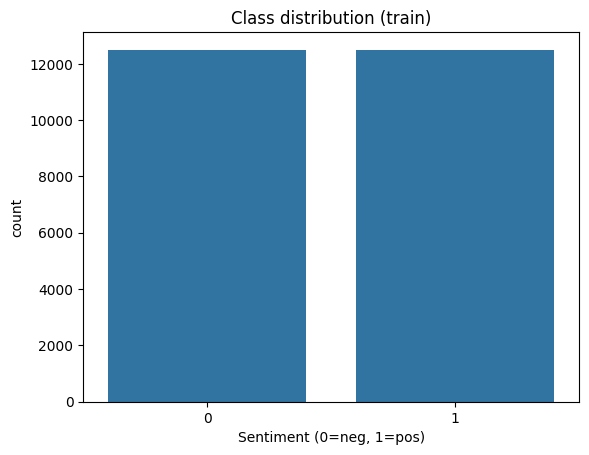

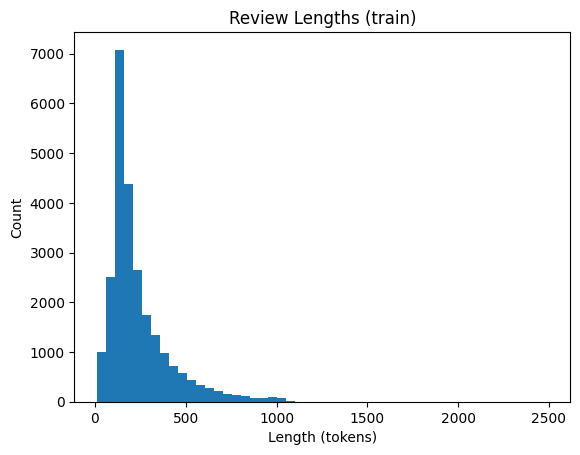

In [ ]:
# 1) Class distribution
sns.countplot(x=y_train)
plt.title("Class distribution (train)")
plt.xlabel("Sentiment (0=neg, 1=pos)")
plt.show()

# 2) Histogram of review lengths
plt.hist(review_lengths, bins=50)
plt.title("Review Lengths (train)")
plt.xlabel("Length (tokens)")
plt.ylabel("Count")
plt.show()


In [ ]:
from collections import Counter

decoded_reviews = [decode_review(r) for r in x_train[:5000]]
all_words = " ".join(decoded_reviews).split()
freq = Counter(all_words)
print(freq.most_common(20))


[('<OOV>', 71043), ('the', 68738), ('and', 33462), ('a', 33325), ('of', 29848), ('to', 27750), ('is', 21901), ('br', 20864), ('in', 19311), ('it', 15966), ('i', 15455), ('this', 15235), ('that', 14250), ('as', 9824), ('was', 9719), ('for', 9121), ('with', 8883), ('but', 8788), ('movie', 8649), ('film', 7687)]


In [ ]:
maxlen = 200
x_train_padded = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_padded  = pad_sequences(x_test,  maxlen=maxlen, padding='post', truncating='post')

print(x_train_padded.shape, x_test_padded.shape)


(25000, 200) (25000, 200)


In [ ]:
X_train_text = np.array([decode_review(r) for r in x_train])
X_test_text  = np.array([decode_review(r) for r in x_test])
y_train = np.array(y_train)
y_test  = np.array(y_test)


In [ ]:
X_train_txt, X_val_txt, y_train_txt, y_val_txt = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [ ]:
max_features = 10000

count_vect = CountVectorizer(max_features=max_features)
X_train_bow = count_vect.fit_transform(X_train_txt)
X_val_bow   = count_vect.transform(X_val_txt)
X_test_bow  = count_vect.transform(X_test_text)


In [ ]:
tfidf_vect = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf_vect.fit_transform(X_train_txt)
X_val_tfidf   = tfidf_vect.transform(X_val_txt)
X_test_tfidf  = tfidf_vect.transform(X_test_text)


In [ ]:
tfidf_vect_bigram = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))


In [ ]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_bow, y_train_txt)

y_val_pred_nb = nb_clf.predict(X_val_bow)
print("NB Accuracy:", accuracy_score(y_val_txt, y_val_pred_nb))
print(classification_report(y_val_txt, y_val_pred_nb))


NB Accuracy: 0.8304
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      2500
           1       0.85      0.80      0.83      2500

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



In [ ]:
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_tfidf, y_train_txt)

y_val_pred_log = log_clf.predict(X_val_tfidf)
print("LogReg Accuracy:", accuracy_score(y_val_txt, y_val_pred_log))
print(classification_report(y_val_txt, y_val_pred_log))


LogReg Accuracy: 0.8794
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2500
           1       0.87      0.90      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [ ]:
scores = cross_val_score(log_clf, X_train_tfidf, y_train_txt, cv=3, scoring='accuracy')
print("CV accuracies:", scores)
print("Mean CV accuracy:", scores.mean())


CV accuracies: [0.88180591 0.87985601 0.88328833]
Mean CV accuracy: 0.881650081912346


In [ ]:
vocab_size = num_words
embedding_dim = 128
lstm_units = 64

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(lstm_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x_train_padded, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop]
)


C:\Users\kamali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.5383 - loss: 0.6889 - val_accuracy: 0.6350 - val_loss: 0.6303
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.5953 - loss: 0.6642 - val_accuracy: 0.5514 - val_loss: 0.6714
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.6844 - loss: 0.5749 - val_accuracy: 0.6646 - val_loss: 0.6477


In [ ]:
test_loss, test_acc = model.evaluate(x_test_padded, y_test, verbose=0)
print("Test accuracy (LSTM):", test_acc)


Test accuracy (LSTM): 0.627240002155304


In [ ]:
from sklearn.svm import LinearSVC
svc_clf = LinearSVC()
svc_clf.fit(X_train_tfidf, y_train_txt)
print("SVC val accuracy:", accuracy_score(y_val_txt, svc_clf.predict(X_val_tfidf)))


SVC val accuracy: 0.8842


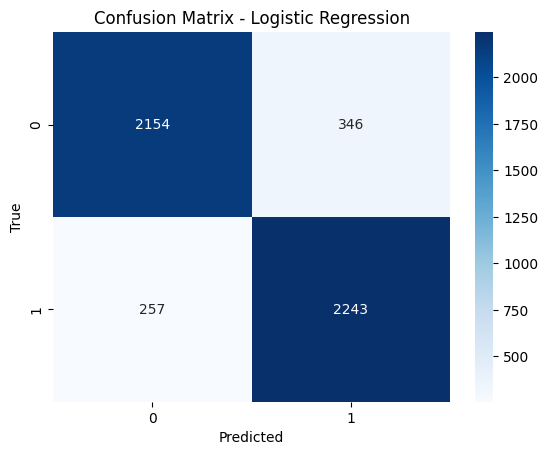

In [ ]:
cm = confusion_matrix(y_val_txt, y_val_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


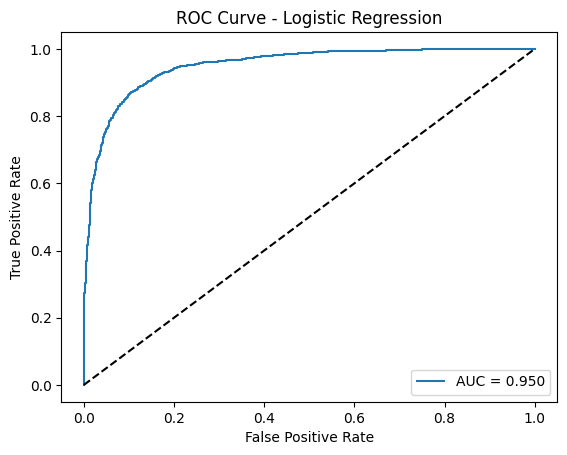

In [ ]:
y_val_proba_log = log_clf.predict_proba(X_val_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_txt, y_val_proba_log)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


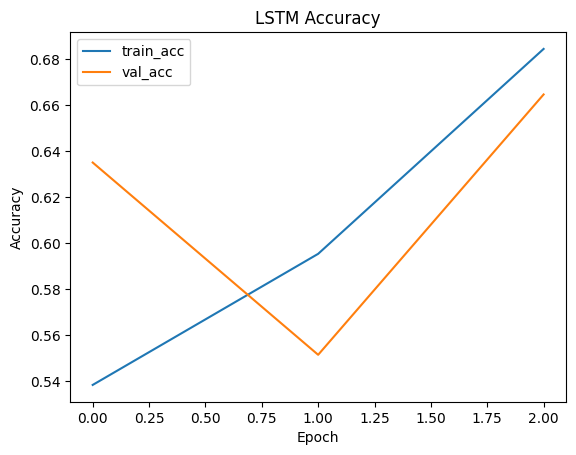

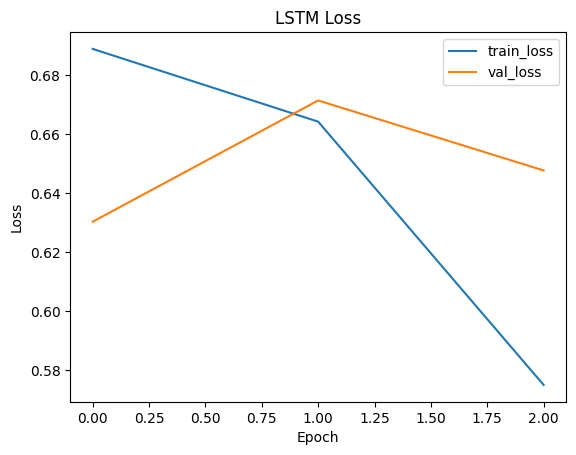

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("LSTM Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("LSTM Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


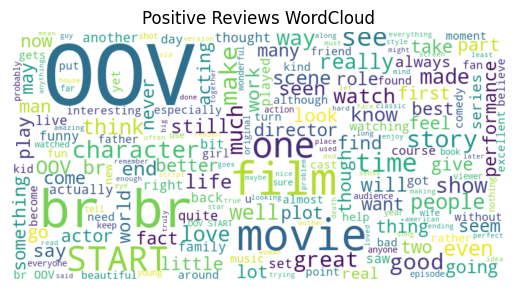

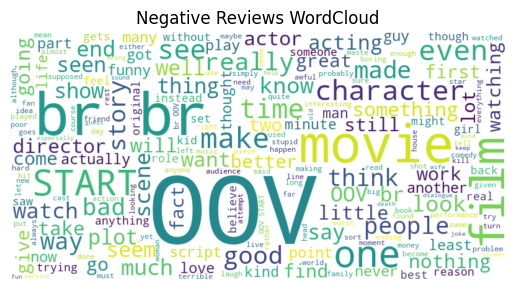

In [ ]:
pos_text = " ".join(X_train_text[y_train == 1])
neg_text = " ".join(X_train_text[y_train == 0])

wc_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")
plt.show()

plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")
plt.show()


In [ ]:
param_grid = {'alpha': [0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid, cv=3, scoring='accuracy')
grid_nb.fit(X_train_bow, y_train_txt)
print("Best params:", grid_nb.best_params_)
print("Best CV score:", grid_nb.best_score_)


Best params: {'alpha': 0.1}
Best CV score: 0.835500026678834


In [ ]:
results = []

def evaluate_model(name, y_true, y_pred):
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    })

evaluate_model("Naive Bayes (BoW)", y_val_txt, y_val_pred_nb)
evaluate_model("LogReg (TF-IDF)", y_val_txt, y_val_pred_log)
# add other models, e.g., SVC, LSTM (using threshold 0.5 on probabilities)

results_df = pd.DataFrame(results)
print(results_df)


               Model  Accuracy  Precision  Recall        F1
0  Naive Bayes (BoW)    0.8304   0.851190  0.8008  0.825227
1    LogReg (TF-IDF)    0.8794   0.866358  0.8972  0.881509


In [ ]:
mis_idx = np.where(y_val_txt != y_val_pred_log)[0][:10]
for i in mis_idx:
    print("True:", y_val_txt[i], "Pred:", y_val_pred_log[i])
    print(X_val_txt[i])
    print("-" * 80)


True: 0 Pred: 1
<START> chris rock apparently desperate for a <OOV> star vehicle which would cross his appeal over to white and mainstream black audiences <OOV> the hit 1978 comedy heaven can wait with an urban agenda he plays a struggling comedian involved in a car accident who has his soul removed too soon from his body consequently his angels must find another body to place him in and can only come up with that of a white businessman <OOV> a movie as bland and sentimental as heaven can wait only shows that <OOV> eye was on the box office this was strictly a corporate move organized by the most <OOV> of hollywood players why not <OOV> for something <OOV> or more memorable than a silly reincarnation comedy that <OOV> with an evening at the apollo terrific supporting cast including the usually reliable <OOV> king the wonderful mark <OOV> <OOV> sykes eugene levy and terrific frankie <OOV> do what they can but rock seems awkward and unsure of himself throughout 1 2 from
-----------------

In [ ]:
pip install streamlit



     ---------------------------------------- 9.0/9.0 MB 32.0 MB/s eta 0:00:00
     ------------------------------------- 795.4/795.4 kB 25.3 MB/s eta 0:00:00
     ---------------------------------------- 208.2/208.2 kB ? eta 0:00:00
     --------------------------------------- 28.1/28.1 MB 36.4 MB/s eta 0:00:00
     ---------------------------------------- 79.1/79.1 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 6.9/6.9 MB 44.2 MB/s eta 0:00:00
     ------------------------------------- 430.8/430.8 kB 28.0 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
results = []

def add_result(name, y_true, y_pred):
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    })

add_result("Naive Bayes (BoW)", y_val_txt, y_val_pred_nb)
add_result("LogReg (TF-IDF)", y_val_txt, y_val_pred_log)

# LSTM uses test set directly
y_test_pred_lstm = (model.predict(x_test_padded) > 0.5).astype("int32").ravel()
add_result("LSTM", y_test, y_test_pred_lstm)

results_df = pd.DataFrame(results)
results_df


782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step


,Model,Accuracy,Precision,Recall,F1
0,Naive Bayes (BoW),0.83040,0.851190,0.80080,0.825227
1,LogReg (TF-IDF),0.87940,0.866358,0.89720,0.881509
2,LSTM,0.62724,0.591719,0.82088,0.687712


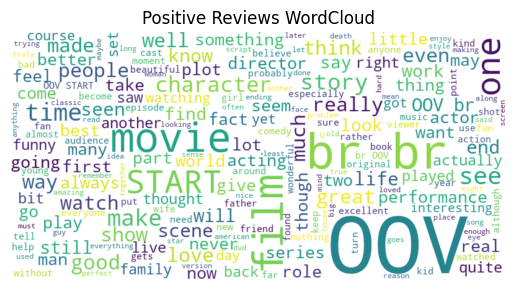

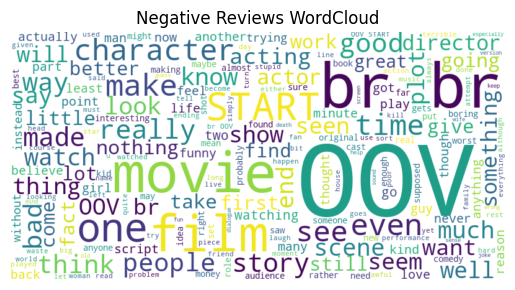

In [ ]:
pos_text = " ".join(X_train_text[y_train == 1])
neg_text = " ".join(X_train_text[y_train == 0])

wc_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")
plt.show()

plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")
plt.show()
